In [34]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [36]:
# 데이터 불러오기
past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')
store = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/store.csv')


# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['year']=pd.DatetimeIndex(data.Date).year
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# 데이터 가공 : StateHoliday
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체

# data del(open)
open = data[data['Open']==0].index
data.drop(open,inplace=True)

# 결측값 처리
data = data.dropna(axis=0)

# store 이름 제거
data = data.drop(['Store'],axis=1)
data = data.drop(['Open'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Customers', 'CompetitionDistance', 'year', 'Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)
digital_data
# 표준화
scaler = MinMaxScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data=categorey_data, columns=onehotencoding_cols)


# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 형 통일
data = data.astype({'Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

data = data = data.drop(['StateHoliday_b','StateHoliday_a'],axis=1)

pd.options.display.max_columns = None

data

C:\Users\rlaeo\AppData\Local\Temp\ipykernel_14416\910635051.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')


,Customers,CompetitionDistance,year,Month,Day,Sales,Promo,SchoolHoliday,Promo2,StateHoliday_c,StateHoliday_d,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0.075122,0.016482,1.0,0.545455,1.000000,5263,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0
1,0.073904,0.016482,1.0,0.545455,0.966667,5020,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,0.070790,0.016482,1.0,0.545455,0.933333,4782,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,0.075799,0.016482,1.0,0.545455,0.900000,5011,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,0.082837,0.016482,1.0,0.545455,0.866667,6102,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842201,0.063752,0.070280,0.0,0.000000,0.200000,6905,1,1,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0
842202,0.045885,0.070280,0.0,0.000000,0.133333,4771,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
842203,0.044126,0.070280,0.0,0.000000,0.100000,4540,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
842204,0.040606,0.070280,0.0,0.000000,0.066667,4297,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [37]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values

In [38]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, shuffle=True)
x_test,x_valid,y_test,y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)

In [39]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_valid = x_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
print('test_data의 row : %s, column : %s'%(x_test.shape[0],x_test.shape[1]))
print('val_data의 row : %s, column : %s'%(x_valid.shape[0],x_valid.shape[1]))
scaler = MinMaxScaler()
scaler.fit(x_train)
scaler.fit(x_test)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_valid = scaler.transform(x_valid)

train_data의 row : 505323, column : 24
test_data의 row : 168441, column : 24
val_data의 row : 168442, column : 24


In [40]:
import datetime
import xgboost as xgb

# XGBoost 모델 설정
model = xgb.XGBRegressor(
    n_estimators=100,  # 나무의 개수 (하이퍼파라미터)
    max_depth=10,       # 나무의 최대 깊이 (하이퍼파라미터)
    learning_rate=0.6, # 학습 속도 (하이퍼파라미터)
    random_state=42
)

# 학습
start = datetime.datetime.now()
model.fit(x_train, y_train)
end = datetime.datetime.now()
time = end - start

In [42]:
# 예측
y_pred = model.predict(x_valid)
# 평가
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)

rmse = np.sqrt(mse)  # RMSE 계산
r2_y_predict = r2_score(y_valid, y_pred)
print(f'rmse: {rmse:.4f}')  # RMSE 출력
print(f'mae: {mae:.4f}')
print('R2 : ', r2_y_predict)
print('처리시간 :', time)

rmse: 514.4269
mae: 355.1253
R2 :  0.9727601173434594
처리시간 : 0:00:27.085513


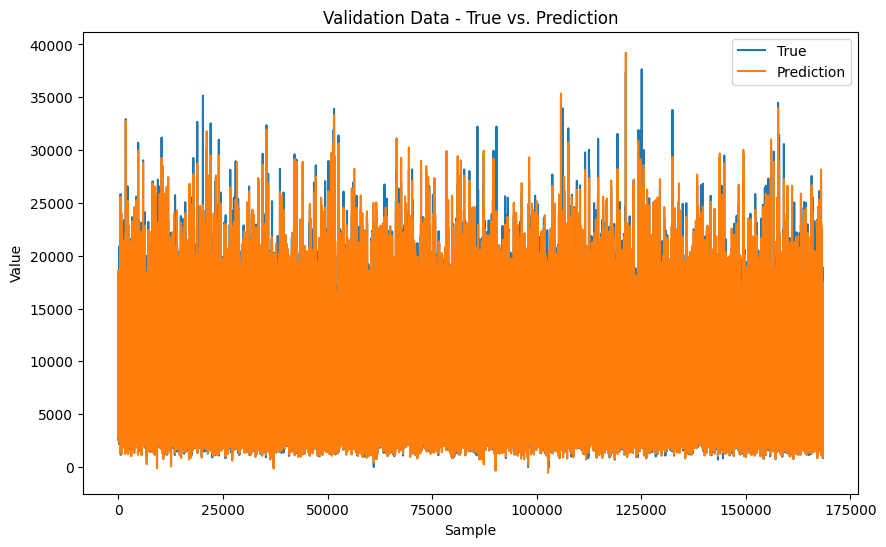

처리시간: 0:00:27.085513


In [44]:
plt.figure(figsize=(10, 6))
plt.plot(y_valid, label='True')
plt.plot(y_pred, label='Prediction')
plt.legend()
plt.title('Validation Data - True vs. Prediction')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()

print('처리시간:', time)